# EXERCISE 6

## 1. Mixture of Gaussians

(1) Define the parameters of 3 Gaussian distribution functions in two dimensions.

In [1]:
# imports needed for Exercise 6
import numpy as np
import math as m
import random
import matplotlib.pyplot as plt

In [2]:
import panda as pd

In [79]:
def bivariate_gauss(x, mu, covarianzmatrix):
    a = (1/(m.sqrt((2* m.pi)**2)) * np.linalg.det(covarianzmatrix))
    b = (m.e ** (np.matmul(np.matmul(-0.5*np.transpose(x-mu), np.linalg.inv(covarianzmatrix)),  x-mu)))
    return a * b

bivariate_gauss(np.array([[100],[100]]), np.array([[2],[2]]), np.array([[1, 0],[0, 1]]))


array([[0.]])

In [3]:
gauss_1 = np.random.multivariate_normal([3,4],[[1,0],[0,1]],100)
gauss_2 = np.random.multivariate_normal([3.5,2],[[0.1,0],[0,3]],100)
gauss_3 = np.random.multivariate_normal([1,4],[[0.9,0],[0,0.2]],100)


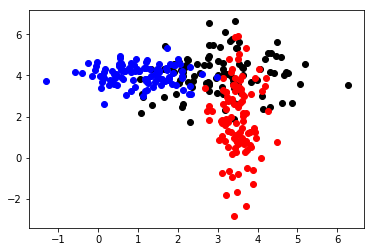

In [5]:
gauss_1_x = gauss_1[:,0]
gauss_1_y = gauss_1[:,1]
gauss_2_x = gauss_2[:,0]
gauss_2_y = gauss_2[:,1]
gauss_3_x = gauss_3[:,0]
gauss_3_y = gauss_3[:,1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gauss_1_x, gauss_1_y, c="black")
ax.scatter(gauss_2_x, gauss_2_y, c="red")
ax.scatter(gauss_3_x, gauss_3_y, c="blue")
plt.show()

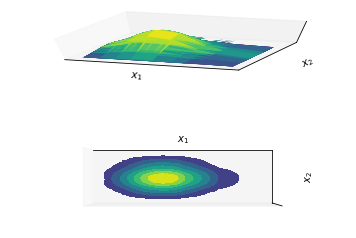

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = gauss_1[:,0]
Y = gauss_1[:,1]
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([3., 4.])
Sigma = np.array([[ 1. , 0.], [0.,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure()
ax1 = fig.add_subplot(3,1,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

In [20]:
# Calculate the probability of a point with the following
multivariate_gaussian(np.array([2.5, 3.5]), np.array([3., 4.]), np.array([[ 1. , 0], [0,  1.]]))

0.12394999430965298